In [1]:
# building a tutorial for UAVSAR data processing and a simple analysis for hackweek
# will need to include downloading data off SQL database, converting it to .tiffs, and making some plots
# should be about 15 mintues

# jack tarricone
# may 4th, 2021 

In [31]:
# beforing importing, you'll need to install these packages to the conda environment the notebook is running on

import os  # for chdir, getcwd, path.basename, path.exists
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import rioxarray
import hvplot.xarray
import hvplot.pandas
import earthpy as et
import re
import codecs # for text parsing code
from osgeo import gdal # for GetRasterBand, Open, ReadAsArray
import numpy as np #for log10, mean, percentile, power
import matplotlib
import matplotlib.pylab as plb # for add_patch, add_subplot, figure, hist, imshow, set_title, xaxis,_label, text 
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
import matplotlib.patches as patches  # for Rectangle
import matplotlib.animation as an # for FuncAnimation
from matplotlib import rc
import glob # for listing files in tiff conversion function
import subprocess
import pandas as pd # for DatetimeIndex 

In [3]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """


    os.chdir(folder)
    int_file = glob.glob(os.path.join(folder, 'int.grd'))

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    print(Lines)
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    print(Samples)
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    print(Latitude)
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    print(Longitude)
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    # Dan, if you wanted to convert to UTM, it would probably be best in this step
    # but also possibly when making the header, where lat/lon is specified 
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs seperate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)

    print(".tiffs have been created")
    return

In [7]:
# set the folder where the newly created rater files are saved as working directory
folder = "/Volumes/JT/projects/uavsar/gmesa/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff"
#uavsar_tiff_convert(folder)

NotADirectoryError: [Errno 20] Not a directory: '/Volumes/JT/projects/uavsar/gmesa/data/02_01_2020/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd/sub/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff'

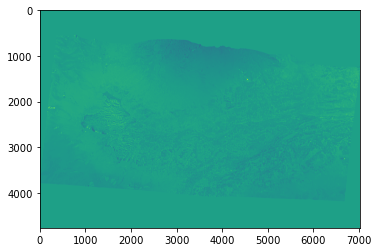

<AxesSubplot:>

In [28]:
path = "/Volumes/JT/projects/uavsar/gmesa/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff"
da = rioxarray.open_rasterio(path, masked = True).squeeze('band')
show(da)

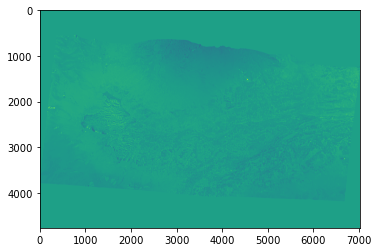

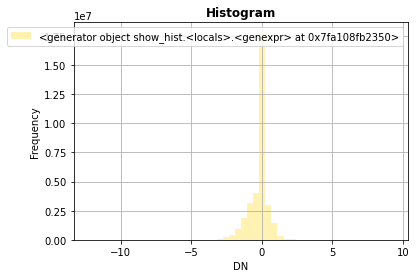

In [40]:
with rio.open(path) as da_raw:
    da_array = da_raw.read(1)

# convert all 0's to nan
show(da_array)
show_hist(da_array, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")
da_array[da_array==0.00000] = np.nan

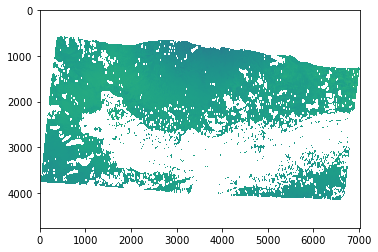

<AxesSubplot:>

In [41]:
show(da_array)

In [5]:
# list all .tiff raster files we just created

# amplitude from the first aquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second aquisition
for amp2 in glob.glob("*amp1.grd.tiff"):
    print(amp1)

# coherence
for cor in glob.glob("*cor.grd.tiff"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"):
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp1.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp1.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.cor.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.unw.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.hgt.grd.tiff


In [16]:
amp1_rast = rio.open(amp1)
amp2_rast = rio.open(amp2)
cor_rast = rio.open(cor)
unw_rast = rio.open(unw)
dem_rast = rio.open(dem)

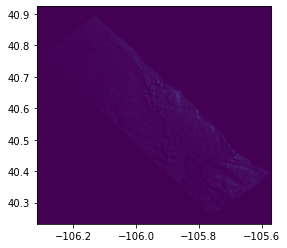

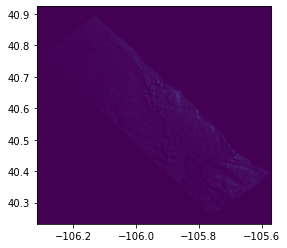

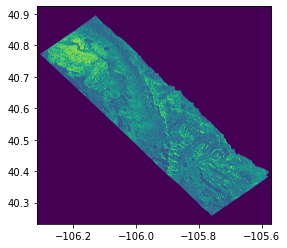

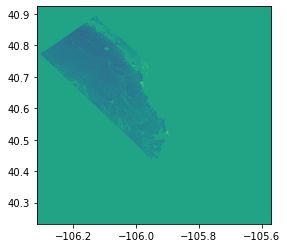

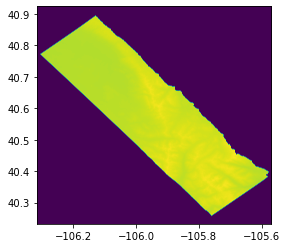

<AxesSubplot:>

In [7]:
show(amp1_rast)
show(amp2_rast)
show(cor_rast)
show(unw_rast)
show(dem_rast)
# note the lat/lon coords
# need change the 0 values to nan, and it takes a few steps to do this

In [8]:
# open raster, convert to np.array
# when converting to np.array, spatial information is lost

####### CHECK TO SEE WHAT SCALE AMP DATA IS SET TOO, BETWEEN 
## ADD DB CONVERSTION, WHAT IS THE REFERENCE VALUE??????

with rio.open(amp1) as amp1_raw:
    amp1_array = amp1_raw.read(1)

# convert all 0's to nan
amp1_array[amp1_array==0] = np.nan

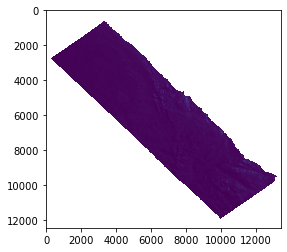

<AxesSubplot:>

In [9]:
# test plot
# when converting to np.array, spatial information is lost
show(amp1_array)

In [10]:
# bring the raster back in to copy the meta data
amp1_rast = rio.open(amp1)
meta = amp1_rast.profile
print(meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 13426, 'height': 12447, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -106.3162824,
       0.0, -5.556e-05, 40.924107), 'tiled': False, 'interleave': 'band'}


In [11]:
# save the cleaned raster
with rio.open('amp1_qc.tiff', 'w', **meta) as amp1_qc:  # open raster dataset in 'w' write mode using the
    amp1_qc.write(amp1_array, indexes=1)  

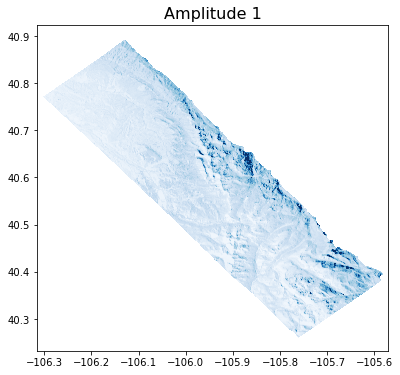

<AxesSubplot:title={'center':'Amplitude 1'}>

In [12]:
# load the new raster back in and quick plot
amp1_qc = rio.open('amp1_qc.tiff')
    
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Amplitude 1",
        fontsize = 16);
show((amp1_qc, 1), cmap='Blues', vmin = 0, vmax = 1)

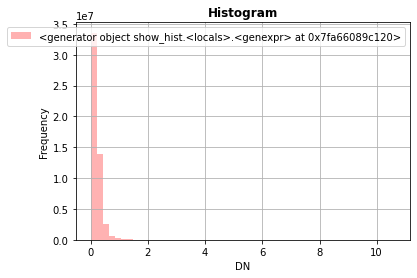

In [13]:
show_hist(amp1_qc, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

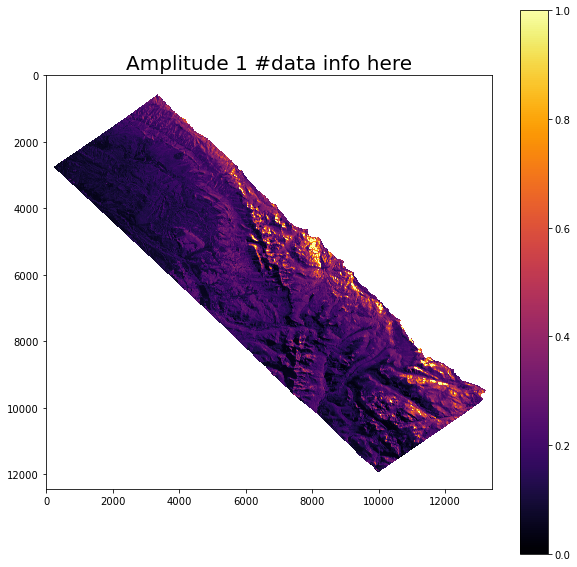

In [15]:
# test matplotlib style of plot bc it has color bar
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Amplitude 1 #data info here", fontsize= 20)
amp1_plot = ax.imshow(amp1_array,
           cmap='inferno',
           vmin=0, vmax=1)

# add legend
colorbar = fig.colorbar(amp1_plot, ax=ax)
plt.show()

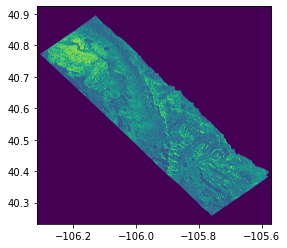

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 13426, 'height': 12447, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -106.3162824,
       0.0, -5.556e-05, 40.924107), 'tiled': False, 'interleave': 'band'}


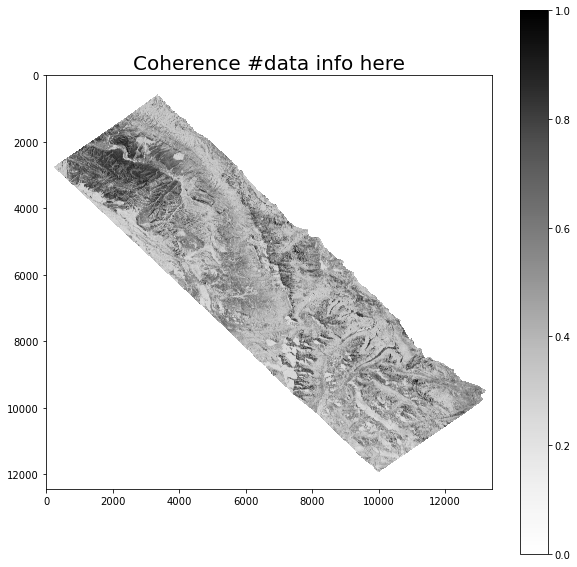

In [17]:
#open cor
cor_rast = rio.open(cor)
show(cor_rast)

# open raster, convert to np.array
# when converting to np.array, spatial information is lost
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1)

# convert all 0's to nan
cor_array[cor_array==0] = np.nan

# plot
fig, ax = plt.subplots(figsize=(10, 10))

# use imshow so that we have something to map the colorbar to
ax.set_title("Coherence #data info here", fontsize= 20)
cor_plot = ax.imshow(cor_array, 
                     cmap='Greys', 
                     vmin=0, vmax=1)

# add colorbar using the now hidden image
fig.colorbar(cor_plot, ax=ax)
# bring the raster back in to copy the meta data
cor_rast = rio.open(cor)
cor_meta = cor_rast.profile
print(cor_meta)

In [ ]:
# save the cleaned raster
with rio.open('cor_qc.tiff', 'w', **meta) as cor_qc:  # open raster dataset in 'w' write mode using the
    cor_qc.write(cor_array, indexes=1) 

In [ ]:
#amp2
with rasterio.open(amp2) as amp2_raw:
    amp2_rast = amp2_raw.read(1)

amp2_rast[amp2_rast==0] = np.nan

#cor
with rasterio.open(cor) as cor_raw:
    cor_rast = cor_raw.read(1)

cor_rast[cor_rast==0] = np.nan

#dem, no data value is -10000
with rasterio.open(dem) as dem_raw:
    dem_rast = dem_raw.read(1)

dem_rast[dem_rast == -10000] = np.nan

In [ ]:
#show(amp1_rast)
#show(amp2_rast)
#show(cor_rast)
show(dem_rast)

In [ ]:
show_hist(
...     dem_rast, bins=50, lw=0.0, stacked=False, alpha=0.3,
...     histtype='stepfilled', title="Histogram")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(amp1_rast, ax=ax1, cmap='Reds', title='Amp 1')
show(dem_rast, ax=ax2, cmap='Greens', title='DEM')
show(cor_rast, ax=ax3, cmap='Blues', title='Coherence')
plt.show()

In [ ]:
print(amp1_raster.RasterCount) # Number of Bands
print(amp1_raster.RasterXSize) # Number of Pixels
print(amp1_raster.RasterYSize) # Number of Lines